In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import numpy as np

import scipy
from scipy import interpolate
import pandas as pd
import itertools

import os
import commands

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

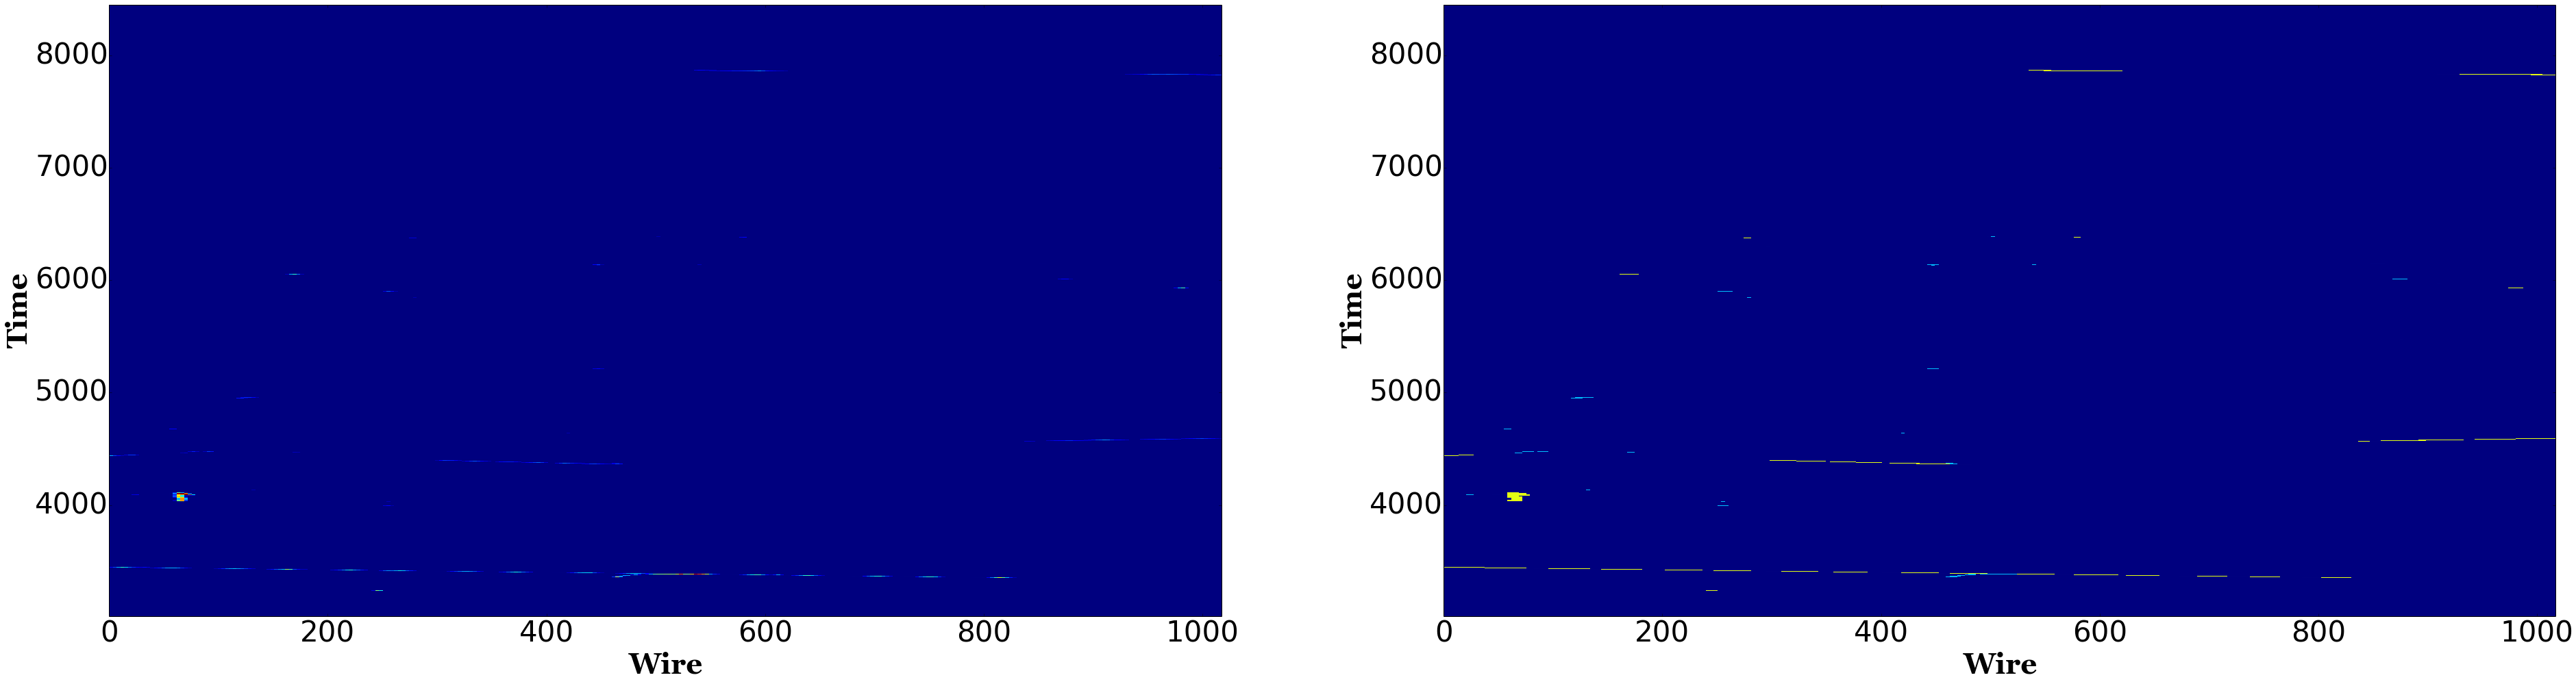

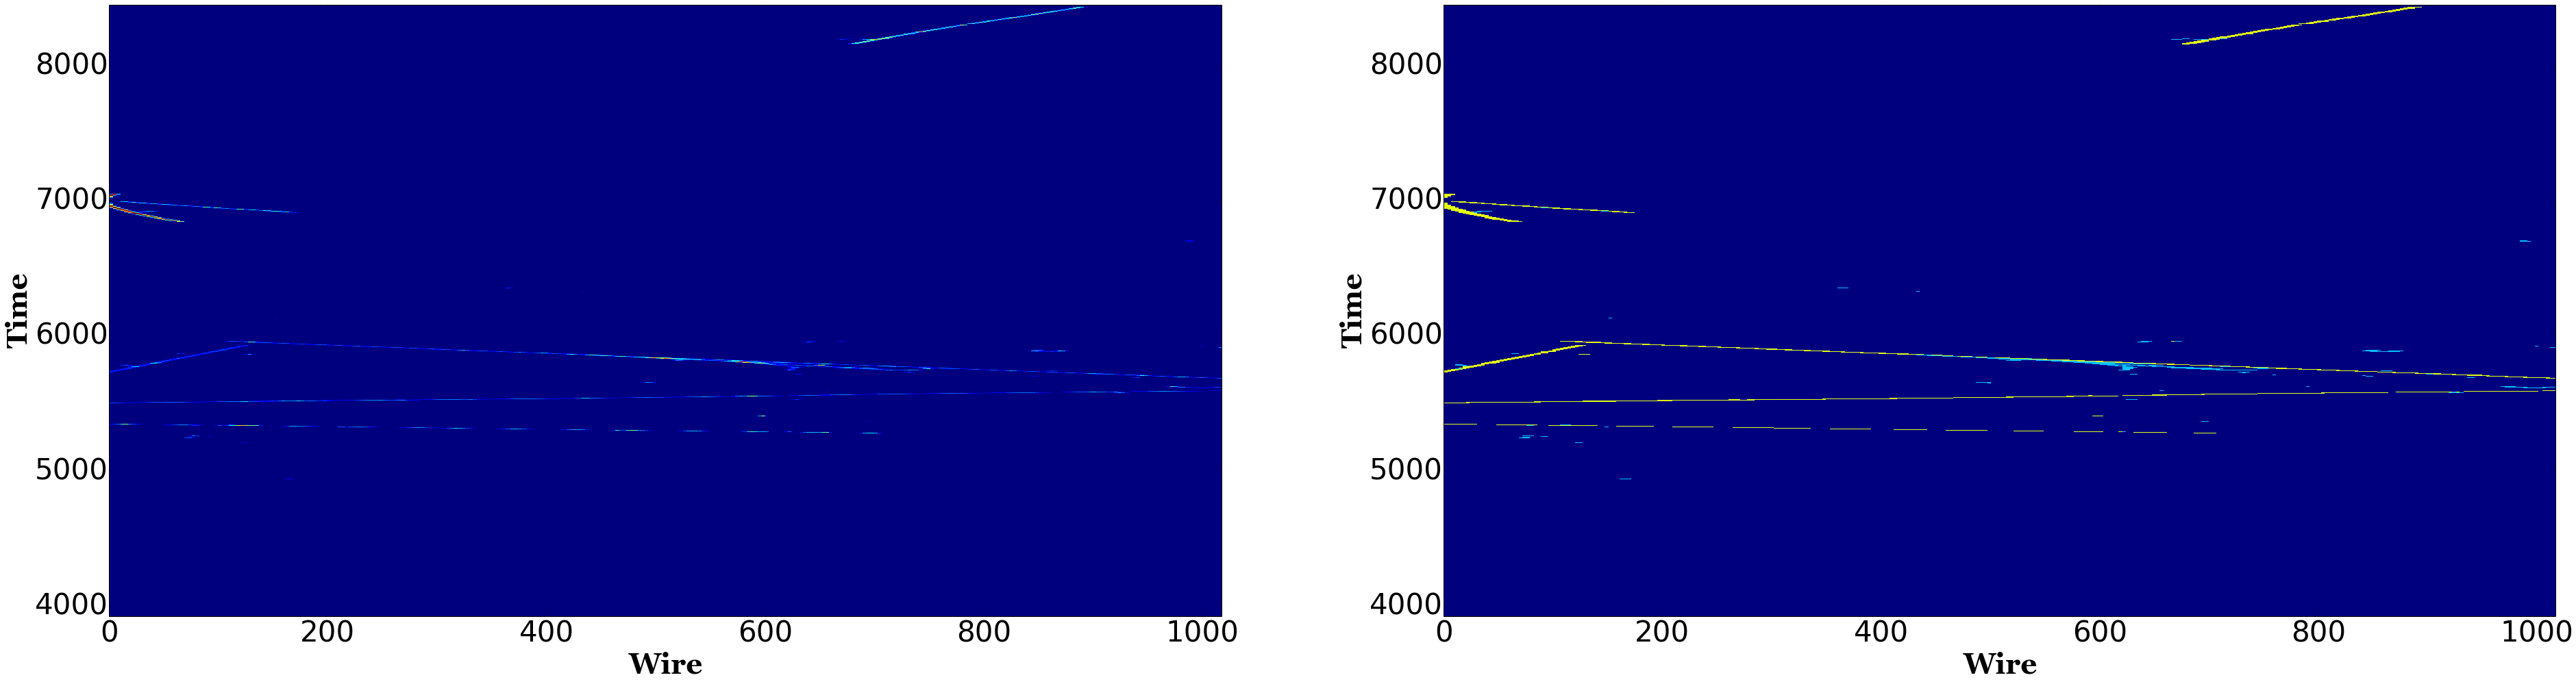

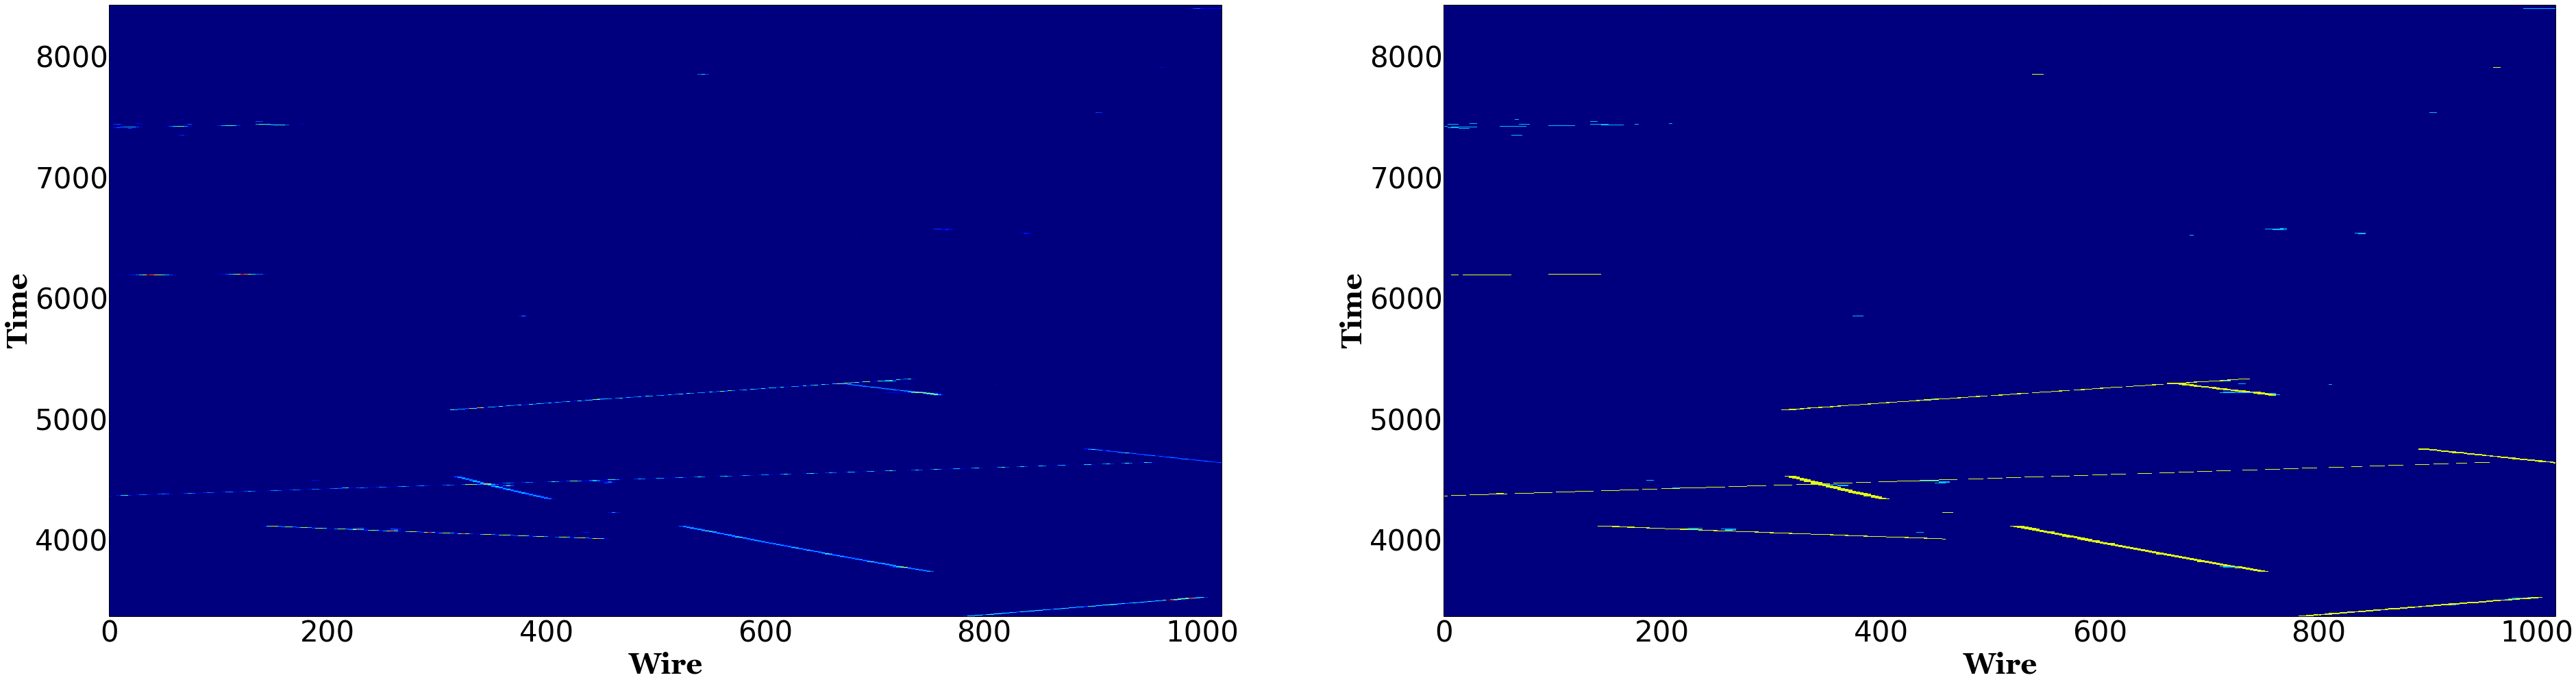

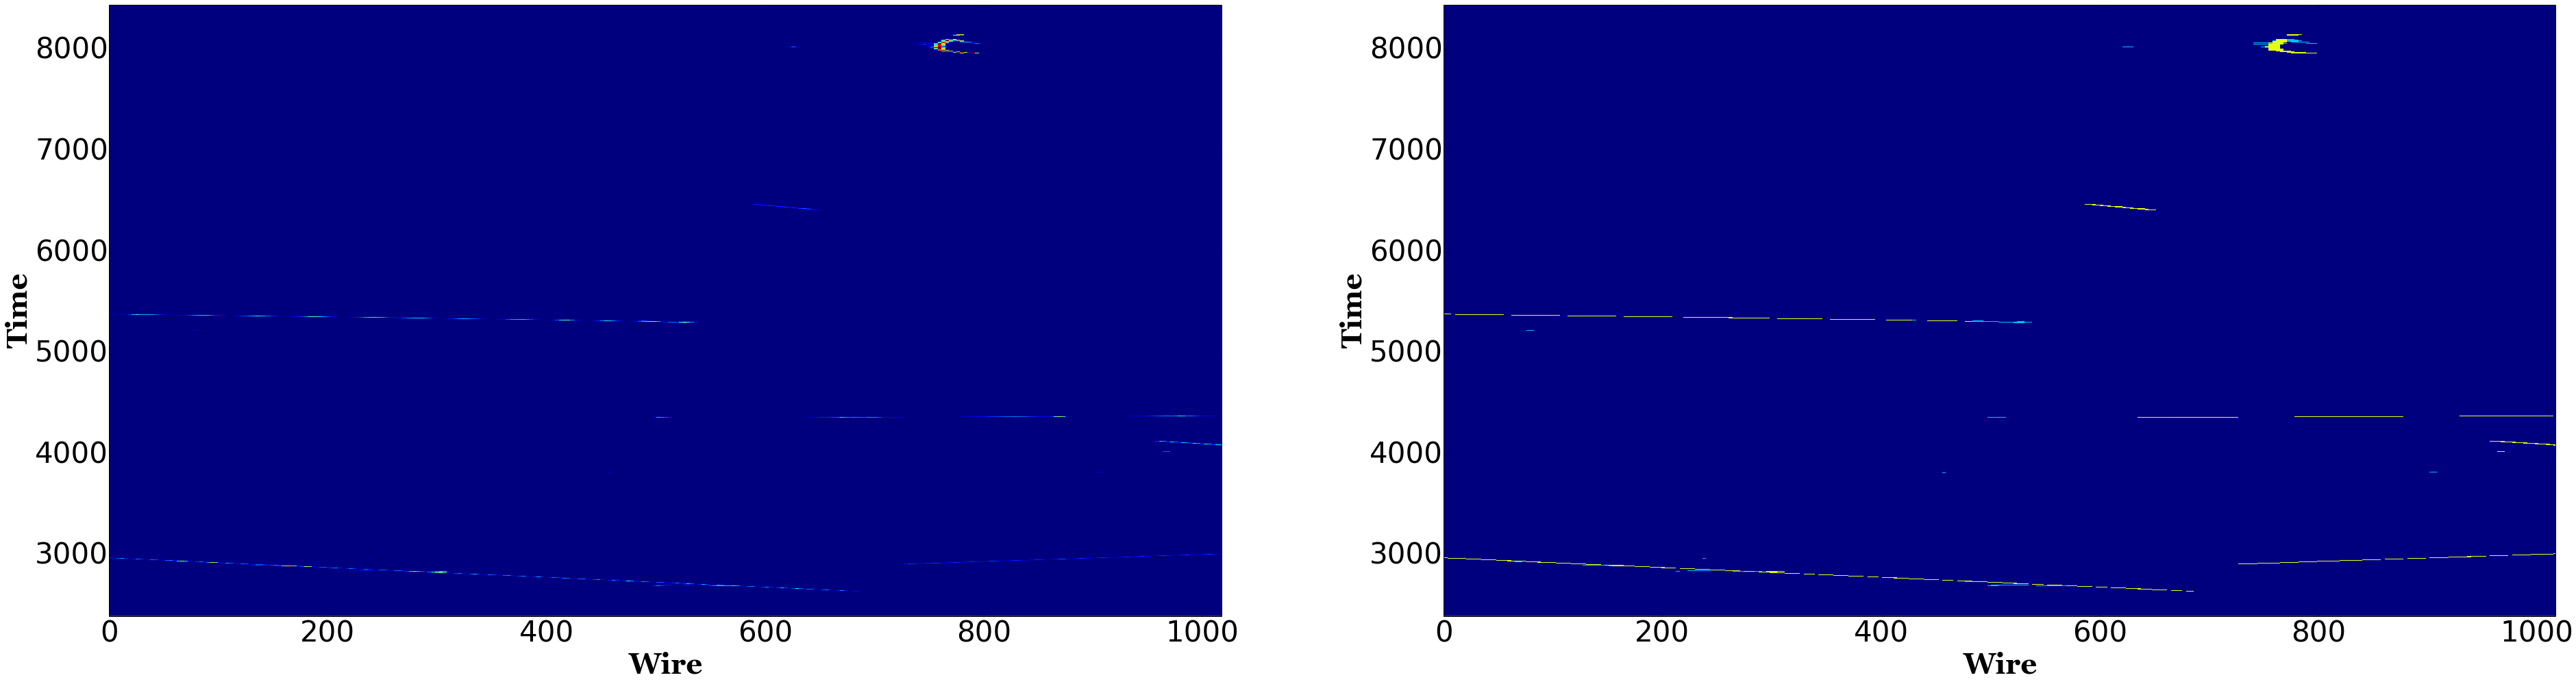

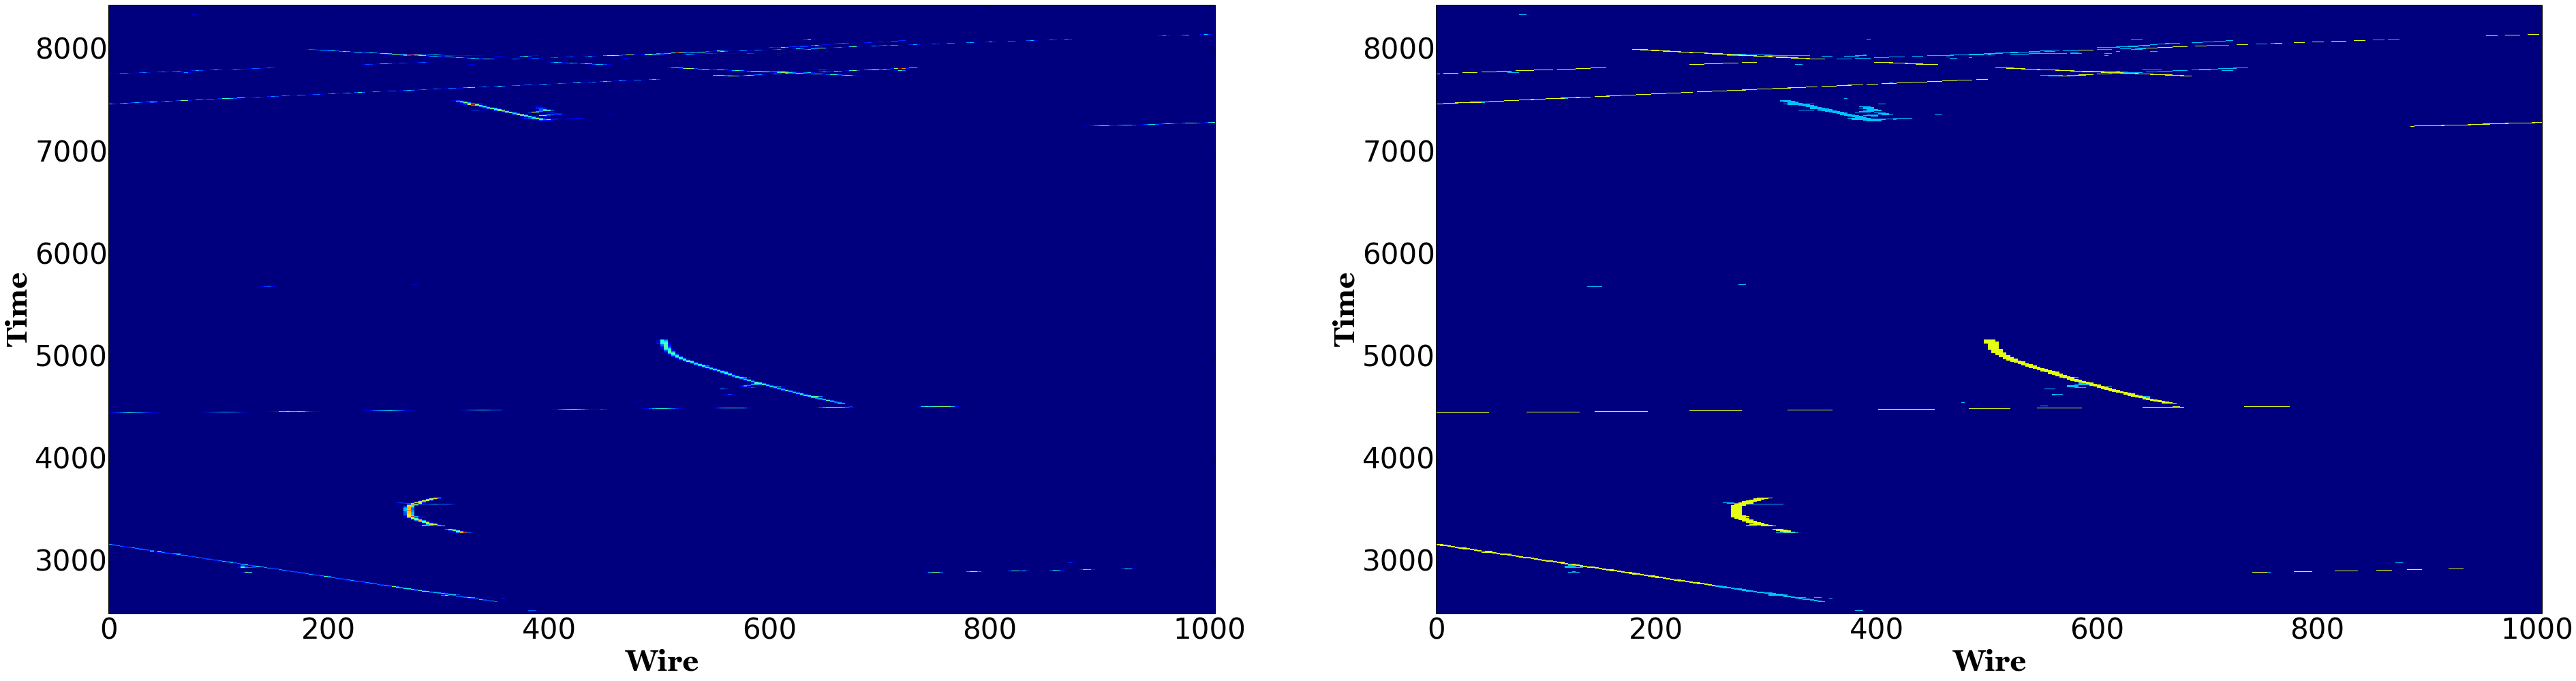

In [11]:
from ROOT import TChain
from larcv import larcv

PLANE=2
FNAME='out.root'

adc_tree=TChain("image2d_tpc_tree")
adc_tree.AddFile(FNAME)

seg_tree=TChain("image2d_uburn_plane%d_tree" % PLANE)
seg_tree.AddFile(FNAME)

display(HTML('<h1>Event Displays</h1>'))

ASPECT=1.0
XLIM_DEFAULT=None
YLIM_DEFAULT=None
entries = range(adc_tree.GetEntries())

for x in entries:
    
    adc_tree.GetEntry(x)
    seg_tree.GetEntry(x)
    
    display(HTML('<h2>Entry %d</h2>' % x))
    
    adc_image    = adc_tree.image2d_tpc_branch.Image2DArray()[PLANE]
    exec('track_image  = seg_tree.image2d_uburn_plane%d_branch.Image2DArray()[1]' % PLANE)
    exec('shower_image = seg_tree.image2d_uburn_plane%d_branch.Image2DArray()[0]' % PLANE)

    meta = adc_image.meta()
    extent    = [meta.min_x(),meta.max_x(),meta.min_y(),meta.max_y()]
    comp_x    = (meta.max_x() - meta.min_x()) / meta.cols()
    comp_y    = (meta.max_y() - meta.min_y()) / meta.rows()
   
    adc_image    = np.flipud(larcv.as_ndarray(adc_image   ).astype(np.float32))
    track_image  = np.flipud(larcv.as_ndarray(track_image ).astype(np.float32))
    shower_image = np.flipud(larcv.as_ndarray(shower_image).astype(np.float32))
    
    ssnet_image  = (((shower_image) > track_image) * 80.) + ((track_image > shower_image) * 160.)
    
    shower_image = shower_image * 255.
    track_image  = track_image  * 255.
    
    TARGET_IMG_ARRAY = [adc_image,ssnet_image]
    
    fig,ax_arr=plt.subplots(1,len(TARGET_IMG_ARRAY),figsize=(64,16),facecolor='w')
    
    nz_pixels=np.where(adc_image>10.0)
    xlim,ylim = (None,None)
    if YLIM_DEFAULT: 
        ylim = YLIM_DEFAULT
    else: 
        ylim = [ (np.min(nz_pixels[0])-10)*comp_y + extent[2], (np.max(nz_pixels[0])+10)*comp_y + extent[2] ]
        if ylim[0] < extent[2]: ylim[0] = extent[2]
        if ylim[1] > extent[3]: ylim[1] = extent[3]
    if XLIM_DEFAULT:
        xlim = XLIM_DEFAULT
    else: 
        xlim = [ (np.min(nz_pixels[1])-10)*comp_x + extent[0], (np.max(nz_pixels[1])+10)*comp_x + extent[0] ]
        if xlim[0] < extent[0]: xlim[0] = extent[0]
        if xlim[1] > extent[1]: xlim[1] = extent[1]
        
    for ax_index, img in enumerate(TARGET_IMG_ARRAY):

        ax = ax_arr[ax_index]
        ax.imshow(img,cmap='jet',interpolation='none',aspect='auto',vmin=0,vmax=255,origin='lower',extent=extent)
        #ax.set_aspect(ASPECT)
        ax.set_ylim(*ylim)
        ax.set_xlim(*xlim)
        ax.tick_params(labelsize=42)
        ax.set_xlabel('Wire',fontsize=42,fontweight='bold',fontname='Georgia')
        ax.set_ylabel('Time',fontsize=42,fontweight='bold',fontname='Georgia')
    #plt.colorbar()
    plt.show()